<h1>Classification and Clustering of Benign and Malignant Tumours</h1>
The classification of tumours for diagnostic purposes is a problem that has recently become tractable for software, thanks to large datasets and improved statistical algorthims. In this notebook I have taken a small dataset with information about malignent and benign tumours and built a model which can categorise them with ~97% accuracy. I've then investigated the data in order to learn which features are associated with being malignant. 

<h3>Load Dependencies</h3>

We first import our libraries.
- Numpy is for matrix maths
- Pandas is for manipulating data in a dataframe
- Sklearn is a machine learning library
- Matplotlib and Seaborn are for plotting charts

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, fbeta_score, accuracy_score, make_scorer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from IPython.display import display
from time import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns

<h3>Preprocess Data</h3>
Let's read in our data and have a look at it

In [2]:
data = pd.read_excel('BCancer.xls')

In [3]:
print(data.shape)

data.head()

(699, 11)


,SampleCode,Thickness,Ucellsize,Ucellshape,MA,Secellsize,BN,BC,NN,Mitoses,Class
0,61634,5,4,3,1,2,0,2,3,1,2
1,63375,9,1,2,6,4,10,7,7,2,4
2,76389,10,4,7,2,2,8,6,1,1,4
3,95719,6,10,10,10,8,10,7,10,7,4
4,128059,1,1,1,1,2,5,5,1,1,2


In [4]:
data.columns = ['SampleCode','ClumpThickness','UniformityOfCellSize','UniformityOfCellShape','MarginalAdhesion',
                'SingleEpithelialCellSize','BareNuclei','BlandChromatin','NormalNucleoli','Mitoses','Class']

data.head()

,SampleCode,ClumpThickness,UniformityOfCellSize,UniformityOfCellShape,MarginalAdhesion,SingleEpithelialCellSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,Class
0,61634,5,4,3,1,2,0,2,3,1,2
1,63375,9,1,2,6,4,10,7,7,2,4
2,76389,10,4,7,2,2,8,6,1,1,4
3,95719,6,10,10,10,8,10,7,10,7,4
4,128059,1,1,1,1,2,5,5,1,1,2


In [5]:
data.isnull().sum()

SampleCode                  0
ClumpThickness              0
UniformityOfCellSize        0
UniformityOfCellShape       0
MarginalAdhesion            0
SingleEpithelialCellSize    0
BareNuclei                  0
BlandChromatin              0
NormalNucleoli              0
Mitoses                     0
Class                       0
dtype: int64

I changed the names of the columns above to make them more useful. This is a clean dataset with no missing values. That doesn't mean there is no preprocessing to do though. Let's drop the SampleCode column since that isn't a factor in predicting tumours. 

I'm also going to relabel the class values from 2 and 4 to -1 and 1. I then scale the other values from -1 to 1 as opposed to 1 to 10. This will make it easier for our model to converge on good values.

In [6]:
def preprocess_data(data):
    data = data.drop(columns=["SampleCode"])
    data['Class'] = data['Class'].replace([2, 4], [-1,1])
    for col in data.columns[:-1]:
        data[col] = scale(list(data[col]))
    return data

In [7]:
data = preprocess_data(data)

In [8]:
data.head()

,ClumpThickness,UniformityOfCellSize,UniformityOfCellShape,MarginalAdhesion,SingleEpithelialCellSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,Class
0,0.206936,0.283845,-0.069850,-0.633247,-0.549561,-0.952012,-0.590067,0.043601,-0.343912,-1
1,1.628538,-0.699995,-0.406574,1.119088,0.354305,1.796673,1.461957,1.354454,0.239570,1
2,1.983939,0.283845,1.277048,-0.282780,-0.549561,1.246936,1.051552,-0.611825,-0.343912,1
3,0.562336,2.251526,2.287222,2.520955,2.162039,1.796673,1.461957,2.337594,3.156977,1
4,-1.214667,-0.699995,-0.743299,-0.633247,-0.549561,0.422330,0.641147,-0.611825,-0.343912,-1


Now we split the data into the predictors and predicted values. 

In [9]:
y = data['Class']
X = data.drop(['Class'], axis=1)

Below is a scatter matrix which lets us visualise the correlation between each column. There are not any easpecially strong relationships except perhaps between UniformityOfCellSize and UniformityOfCellShape. We'll have to put the computer to work to learn more. 

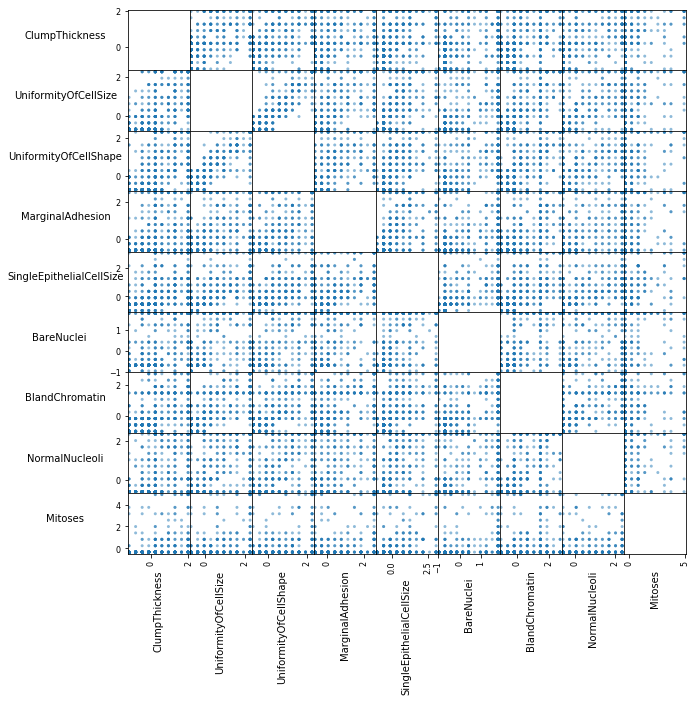

In [10]:
axs = pd.plotting.scatter_matrix(data[X.columns], figsize=(10,10), diagonal='scatter')
n = len(X.columns)
for x in range(n):
    for y_ in range(n):
        # to get the axis of subplots
        ax = axs[x, y_]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

<h3>Classification</h3>
We first split our data into a training and testing set. 20% is set aside for testing. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Which classification technique should we use? Regression? Decision Trees? The answer is to try them all! This dataset isn't very big so that won't be a problem. Below are the five models I've decided to compare.

- Logistic Regression can be used to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

- Support Vector Classifiers attempt to draw a place which can maximise the average distance it is from the points on either size.

- Decision Tree Classifiers use a tree-like model of decisions and their possible consequences.
 
- Random Forest Classifiers are meta estimators that fit a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

- AdaBoost Classifiers are also ensemble methods. They combine and weight weak classifier algorithms to form a strong classifier.

There is also the question of how to measure the performance of each technique. I've chosen three possible measures and chart the performance of each model as measured by them below. They are

- Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations.

- F1 Score is the weighted average of Precision and Recall. Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. Recall is the ratio of correctly predicted positive observations to the all observations in actual class.

- Fbeta Score is similar to the f1 score but weights precision and recall differently. If precision is given more weight, beta will be less than 1. If recall is given more weight, beta will be greater than 1.

In [12]:
m1 = LogisticRegression()
m2 = SVC(kernel='rbf')
m3 = DecisionTreeClassifier()
m4 = RandomForestClassifier()
m5 = AdaBoostClassifier()

In [13]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time()
    learner = learner.fit(X_train, y_train)
    end = time()
    results['train_time'] = end - start
        
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time()
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train, predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['f1_train'] = f1_score(y_train, predictions_train)         
    results['f1_test'] = f1_score(y_test, predictions_test)
    
    results['fbeta_train'] = fbeta_score(y_train, predictions_train, beta=0.5)         
    results['fbeta_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
               
    return results

In [14]:
results = {}
for model in [m1,m2,m3,m4,m5]:
    model_name = model.__class__.__name__
    results[model_name] = {}
    results[model_name] = train_predict(model, X_train, y_train, X_test, y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


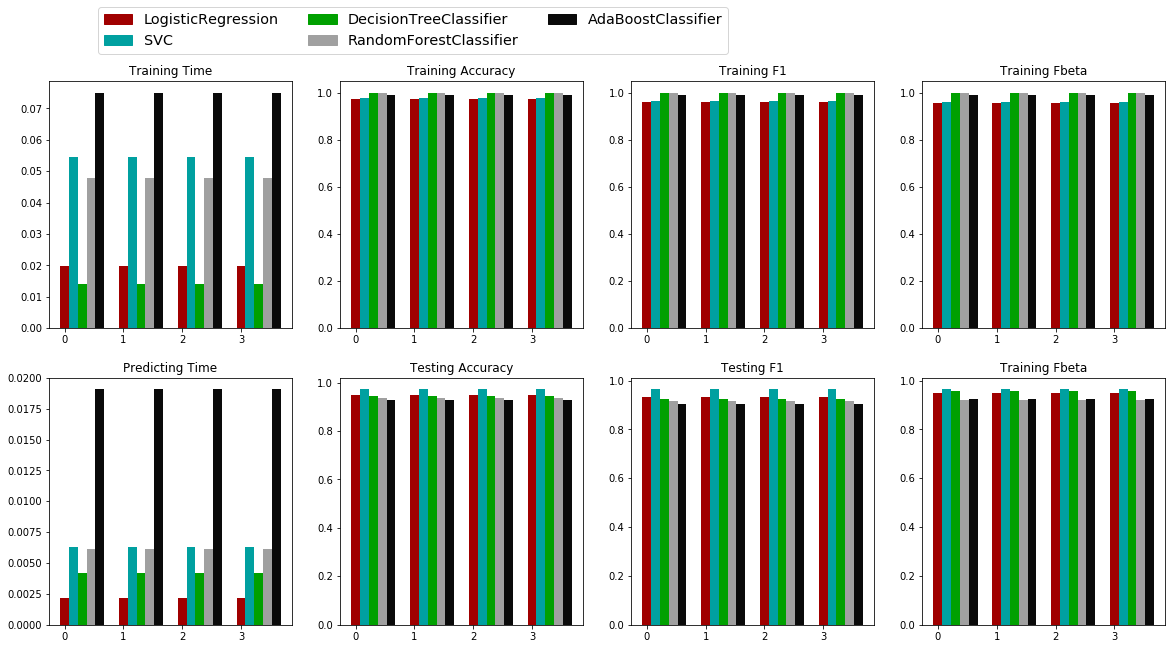

In [15]:
fig, ax = plt.subplots(2, 4, figsize=(20,10))

bar_width = 0.15
colors = ['#A00000','#00A0A0','#00A000','#A0A0A0','#0A0A0A']

for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time','acc_train','f1_train','fbeta_train','pred_time','acc_test','f1_test','fbeta_test']):
            for i in np.arange(4):                
                ax[j//4, j%4].bar(i+k*bar_width,results[learner][metric],width=bar_width,color=colors[k])
                
ax[0, 0].set_title("Training Time")
ax[0, 1].set_title("Training Accuracy")
ax[0, 2].set_title("Training F1")
ax[0, 3].set_title("Training Fbeta")
ax[1, 0].set_title("Predicting Time")
ax[1, 1].set_title("Testing Accuracy")
ax[1, 2].set_title("Testing F1")
ax[1, 3].set_title("Training Fbeta")

patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color=colors[i],label=learner))
    plt.legend(handles=patches,bbox_to_anchor=(-0.8,2.5),loc='upper right',borderaxespad=0,ncol=3,fontsize='x-large')

Well, after all that they all perform about the same! The only areas where they diverge are in their speed. Because this dataset is small, we didn't notice the difference but if it was bigger we would. We'll take the decision tree classifier since it looks like it performs slighter better on the test set and was also quick to run. We now have a simple classifier. If added another row to the dataset, I should be about 97% sure that it has been correctly classified. Of course, it isn't quite that simple. This dataset was quite small and may not be representative of the wider world. 

For the rest of this project though, let us assume that this classifier is working well. How has it come to these conclusions? At the moment it is a bit of a black box. For some purposes we may be happy to leave it that way if the answers it gives are correct more often than the humans' answers. However, there is still value in trying to work out how it comes to its decisions. It may help us make better decisions ourselves, or reveal potential blind spots in the algorithm. 

In [16]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

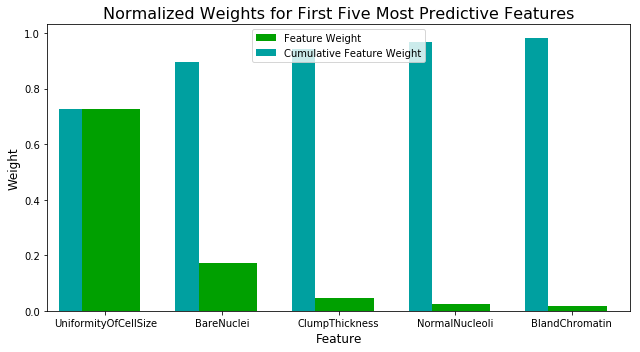

In [17]:
model = DecisionTreeClassifier().fit(X_train, y_train)

importances = model.feature_importances_

feature_plot(importances, X_train, y_train)

Above us I've the five features which are most are most predictive of the tumour's classification. Uniformity of cell size seems to be the most important feature by far followed by barre nuclei. I don't know enough about oncology to be able to say whether or not this passes the smell test. However, some who does might be able to incorporate this data into their diagnosics procedure. Alternatively this may tell us something about how tumour data is gathered and recorded. 

**Principle Component Analysis**
This is a technique which attempts to...

***TODO***

In [18]:
pca = PCA()
X_pca = pca.fit_transform(X)

Text(0.5, 1.0, 'Explained Variance Per Principal Component')

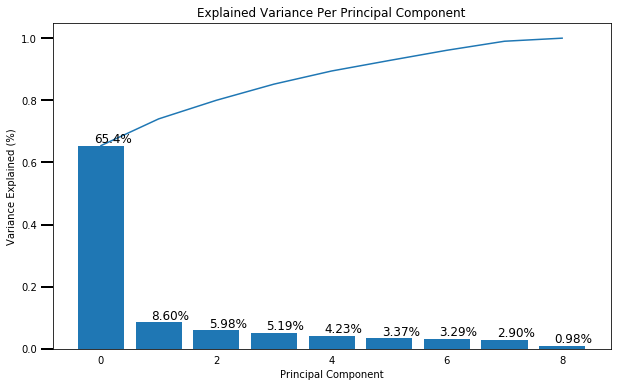

In [19]:
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
cumvals = np.cumsum(vals)
ax.bar(ind, vals)
ax.plot(ind, cumvals)
for i in range(num_components):
    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')

In [20]:
pca = PCA(n_components=9)
X_pca = pca.fit_transform(X)

<h3>Clustering</h3>
It would be interesting to know whether, based on the input features, we can group the tumours into clusters which line up with the tumours' actual categories. In this case, we know we want two clusters so we'll create them and see what proportion of each is malignant. 

First though, a quick sanity check. Let's perform Kmeans with a range of values for K. 

In [29]:
scores = []
for i in range(1,10,1):
    kmeans = KMeans(n_clusters=i).fit(X)
    kmeans_score = np.mean(kmeans.score(X))
    scores.append(kmeans_score)

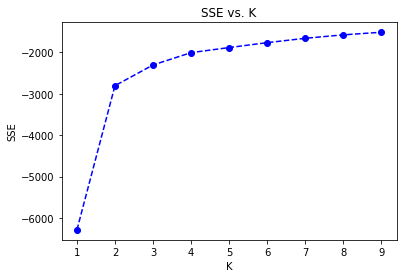

In [30]:
centers = list(range(1,10,1))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

As we can see, there's a very pronounced elbow at two clusters.

In [31]:
kmeans = KMeans(n_clusters=2)
kmeans_model = kmeans.fit(X)
kmeans_prediction = kmeans_model.predict(X)

In [32]:
kmeans_tumour_prediction = kmeans_model.predict(X)

In [36]:
# tumour_count_in_clusters = {0:0,1:0,2:0,3:0}
malignant_count_in_clusters = {0:0,1:0}

for i in zip(kmeans_tumour_prediction, y):
    if i[1] == 1:
        malignant_count_in_clusters[i[0]] += 1
        
malignant_count_in_clusters

{0: 225, 1: 16}

In [37]:
for i in malignant_count_in_clusters:
    malignant_count_in_clusters[i] /= np.unique(kmeans_tumour_prediction, return_counts=True)[1][i]
    
malignant_count_in_clusters

{0: 0.9493670886075949, 1: 0.03463203463203463}

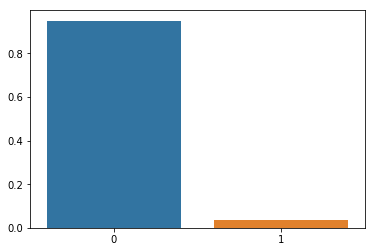

In [38]:
sns.barplot(x=list(malignant_count_in_clusters.keys()),y=list(malignant_count_in_clusters.values()));

Tumours in one cluster are very rare and in the other they are very common. This is encouraging. That the program sorted the tumours so neatly suggests that there really is something in the data that divides the tumours into their respective categories and that that division is in whether they are benign or not.

Now that we have two clear clusters, we can compare them. We will plot a chart displaying which attributes tend to have higher or lower values compared to the other cluster. 

In [39]:
def plot_scaled_comparison(df_sample, kmeans_pred, cluster):
    X = pd.DataFrame.from_dict(
        dict(
            zip(df_sample.columns, pca.inverse_transform(kmeans.cluster_centers_[cluster]))
        ), orient='index').rename(columns={0: 'feature_values'})
    
    X['feature_values_abs'] = abs(X['feature_values'])
    X['feature_values'].plot(kind='barh');
    print(X)

In [40]:
d = {
    'cluster 0' : pd.Series(pca.inverse_transform(kmeans.cluster_centers_[0]), X.columns),
    'cluster 1' : pd.Series(pca.inverse_transform(kmeans.cluster_centers_[1]), X.columns)
    }

test = pd.DataFrame(d)
test

,cluster 0,cluster 1
ClumpThickness,-0.529788,0.271774
UniformityOfCellSize,1.025544,-0.526091
UniformityOfCellShape,-0.283818,0.145595
MarginalAdhesion,0.950963,-0.487832
SingleEpithelialCellSize,1.900891,-0.975132
BareNuclei,-1.550403,0.795337
BlandChromatin,0.873265,-0.447974
NormalNucleoli,-0.213179,0.109358
Mitoses,0.765588,-0.392737


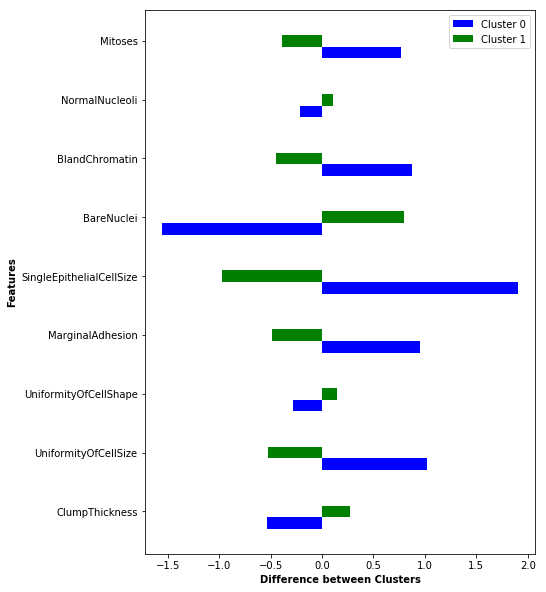

In [42]:
n_groups = len(X.columns) # 9
fig, ax = plt.subplots(figsize=(7,10))
index = np.arange(n_groups)
bar_width = 0.2
 
rects0 = plt.barh(index, test['cluster 0'], bar_width, color='b', label='Cluster 0')
rects1 = plt.barh(index+bar_width, test['cluster 1'], bar_width, color='g', label='Cluster 1')

plt.ylabel('Features', fontweight='bold')
plt.xlabel('Difference between Clusters', fontweight='bold')
plt.yticks(index + bar_width, X.columns)
plt.legend()
 
plt.show()

What have we learnt from this? It looks like in the more malignant cluster, the Bear Nuclei cluster tends to lower and the Single Epithelial Cell Size cluster tends to be higher. These are the two biggest differences. With a larger dataset with more granular labels, this could be useful to onclogists looking to study cancer. We can't attach much significance to these results at the moment. Nevertheless, it has been a useful learning experience.